# Assignment 3

In [2]:
# Imports
import numpy as np
import scipy as sp
import copy
import scipy.sparse
import matplotlib.pyplot as plt
from numba import njit
from scipy.sparse import csc_matrix
import time
from scipy.optimize import curve_fit
import scipy.stats as stats
from numba import njit
from matplotlib.animation import FuncAnimation

In [3]:
print("Hello world")

Hello world


___
## 1.1 Eigenmodes of drums or membranes of different shapes

In [4]:
# Helper function

### A.1 Discretize

### A.2 Formulate a matrix version
Of the eigenvalue problem, taking the boundary conditions into account

### A.3 Draw a figure showing the discretization points and positions
Show and explain the shape of the matrix

In [5]:
def create_tri_diagonal_matrix(a,b,c, square_size:tuple, boundary='fixed', boundary_value=0):



    matrix = np.zeros((square_size))

    matrix.copy()


    np.fill_diagonal(matrix[1:], a)  # superdiagonal
    np.fill_diagonal(matrix, b) # diagonal
    np.fill_diagonal(matrix[:, 1:], c)  # subdiagonal

    # set boundary value
    matrix[:,0] = boundary_value
    matrix[0,:] = boundary_value
    matrix[:,-1] = boundary_value
    matrix[-1,:] = boundary_value

    
    
    return matrix

In [6]:
def make_grid(shape:tuple, boundaries = 'fixed', boundary_value = 0):
    grid = np.ones(shape)

    # i,j, domain
    grid[:,0] = boundary_value
    grid[0,:] = boundary_value
    grid[:,-1] = boundary_value
    grid[-1,:] = boundary_value

    return grid

In [7]:
def calc_eigenvals_and_eigenvecs(grid, Lx=1, Ly=1, n_eigenvals_n_vecs=5, solver='sparse'):
    Nx, Ny = grid.shape
    if solver == 'sparse':
        M = csc_matrix((Nx*Ny, Nx*Ny))
    else:
        M = np.zeros((Nx*Ny, Nx*Ny))

    # stepsizes
    delta_x = Lx/(Nx-1)
    delta_y = Ly/(Ny-1)

    for i in range(Nx):
        for j in range(Ny):
            if grid[i,j] != 0:

                # Defining indices

                # Mapping 2d object to 1d flattened array using row major indexing:
                index_midcell = i * Ny + j
                
                # Consider that we still want our 2d Central finite difference (both in x and y direction)
                # stencil to operate on the middle cell and 4 adjacents (top, down, left & right) cells, 
                # therefor we use row major indexing to map each of these neighbours to the right index so that we can set them to the right value
                index_leftcell = (i-1) * Ny + j
                index_rightcell = (i+1) * Ny + j
                index_topcell = (i) * Ny + (j + 1)
                index_bottomcell = (i) * Ny + (j - 1)

                # Modifying middle cell
                M[index_midcell,index_midcell] = -2/delta_x**2 - 2/delta_y**2
                if i > 0:
                    # Modifcing left cell
                    M[index_midcell,index_leftcell] = 1/delta_x**2
                if i < Nx - 1:
                    # Modifcing right cell
                    M[index_midcell,index_rightcell] = 1/delta_x**2
                if j > 0:
                    # Modifcing top cell
                    M[index_midcell,index_bottomcell] = 1/delta_y**2
                if j < Ny - 1:
                    # Modifcing bottom cell
                    M[index_midcell,index_topcell] = 1/delta_y**2

    if solver == 'sparse':           
        M = M.tocsc()  # Convert to CSC format for eigenvalue computation
        # Get smallest eigenvalues
        eigenvals, eigenvecs = scipy.sparse.linalg.eigs(M, k=n_eigenvals_n_vecs, which='SM')
    else:
        eigenvals, eigenvecs = scipy.linalg.eig(M)
        # Sort eigenvalues and eigenvectors together by the eigenvalues
        sorted_indices = np.argsort(np.abs(eigenvals))
        eigenvals = eigenvals[sorted_indices][:n_eigenvals_n_vecs]
        eigenvecs = eigenvecs[:, sorted_indices][:, :n_eigenvals_n_vecs]
           
    # Returning only the real pars
    # return (np.real(eigenvals), np.real(eigenvecs))
    return (np.real(eigenvals), np.real(eigenvecs))

In [8]:
# Draw a small example, number elements, think abouth connected elements...
# TODO



___
### B.1 Solve the eigenvalue problem
- Explain method used: scipy.linalg.eig(), eigh(), eigs() or other
- Plot eigenvectors v for some of the smallest eigenvalues, for L=1
- Lavel the plots with their frequencies

**EXTRA IDEA**: Compare it with analytical solution: see https://math.jhu.edu/~js/Math417/wave_2D.pdf

### B.1.1 Square side L

### B.1.2 Rectangle sides L and 2L

In [9]:
def plot_eigenmodes(eigenvals, eigenvecs, n_eigenvals_n_vecs, Nx, Ny, Lx, Ly):
    # Setting the figure's DPI and creating subplots
    fig, axes = plt.subplots(1, n_eigenvals_n_vecs, figsize=(n_eigenvals_n_vecs * 5, 5), dpi=250)
    
    # Iterating over the number of eigenvalues and eigenvectors to plot
    for i in range(n_eigenvals_n_vecs):
        eigenvector = eigenvecs[:, i].reshape((Nx, Ny))  # Reshaping the eigenvector to fit the spatial grid
        ax = axes[i] if n_eigenvals_n_vecs > 1 else axes  # Handling single subplot differently
        c = ax.imshow(eigenvector, cmap='viridis', extent=[0, Lx, 0, Ly])  # Displaying the eigenvector as an image
        ax.set_title(f"Mode {i+1} (λ={eigenvals[i]:.4f})")  # Setting the title with the eigenvalue
        fig.colorbar(c, ax=ax)  # Adding a colorbar for the plot

    plt.show()  # Displaying the plot

In [10]:
grid = make_grid(shape = (50,50))
eigenvals, eigenvecs = calc_eigenvals_and_eigenvecs(grid)
n_eigenvals_n_vecs = 5

c:\Users\nitai\anaconda3\envs\scicomp\Lib\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


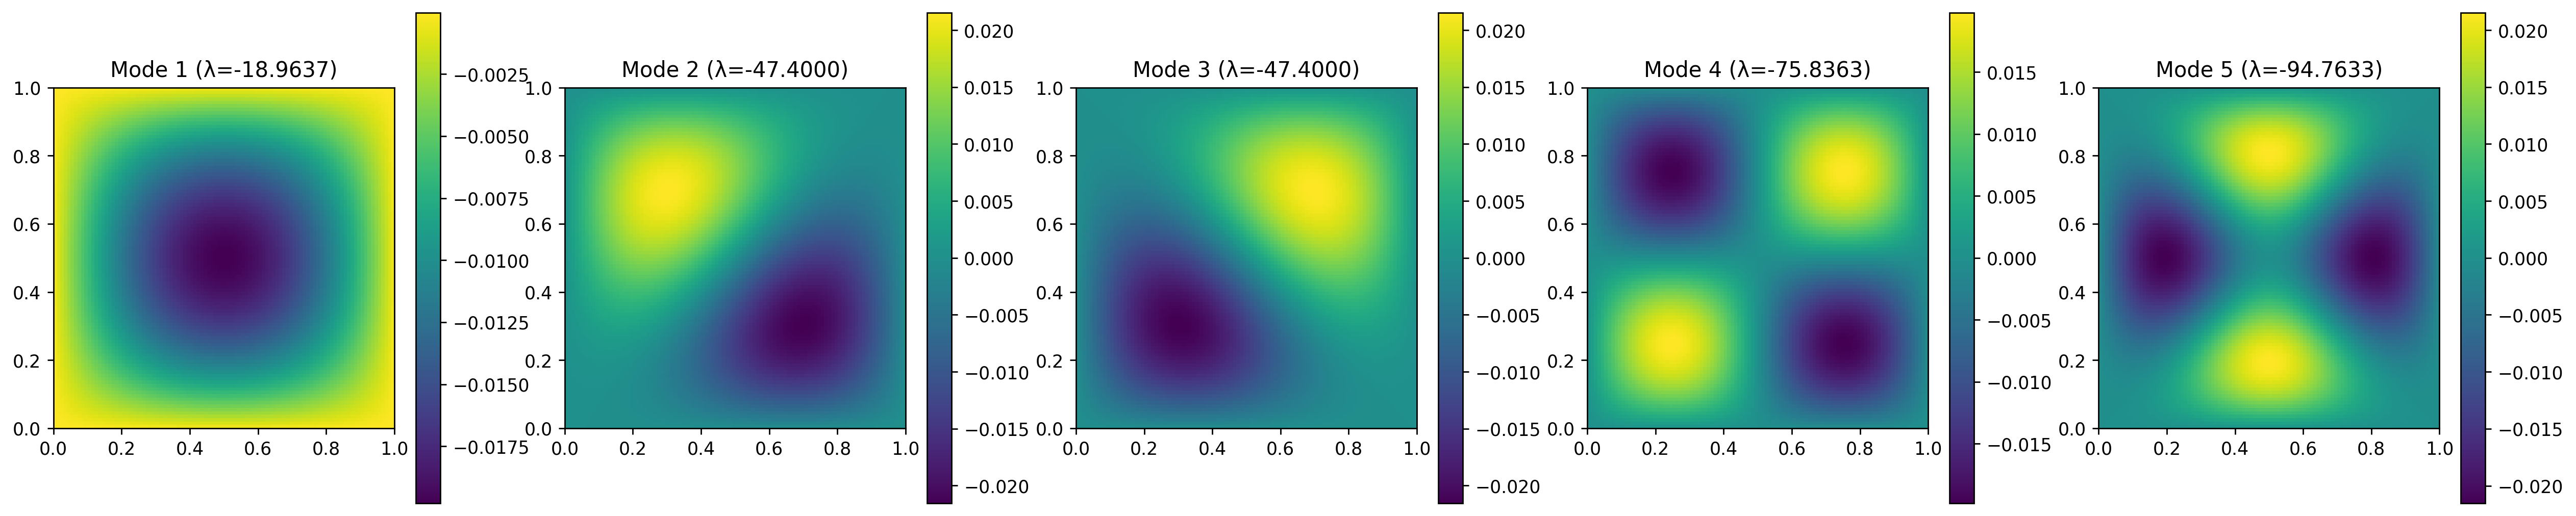

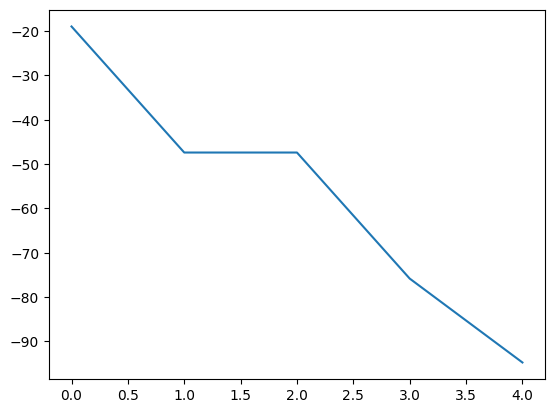

In [11]:
n_eigenvals_n_vecs = 5
eigenvals, eigenvecs = calc_eigenvals_and_eigenvecs(grid)
Lx = 1
Ly = 1
Nx = 100
Ny = 100


# grid = make_grid(shape = (50,50))
# Adding boundary conditions causes error without noise, right now just considering the interior by constructing a simple grid without boundaryes using np.ones
grid = np.ones((Nx, Ny))
eigenvals_2, eigenvecs_2 = calc_eigenvals_and_eigenvecs(grid,Lx=Lx,Ly=Ly  solver='regular')
n_eigenvals_n_vecs = 5

# Plotting
plot_eigenmodes(eigenvals_2, eigenvecs_2, n_eigenvals_n_vecs, Nx, Ny, Lx, Ly)


plt.plot(eigenvals_2)

In [22]:
def generate_grid(Nx, Ny, shape='square', Lx=1, Ly=1):
    grid = np.zeros((Nx, Ny))  # Initialize the grid with zeros
    if shape == 'circle':
        radius = L / 2
        center_x, center_y = Nx // 2, Ny // 2

        # Create a grid of x and y coordinates
        x, y = np.linspace(0, Lx, Nx), np.linspace(0, Ly, Ny)
        x, y = np.meshgrid(x, y)

        # Calculate the distance of each point from the center
        distance_from_center = (x - center_x)**2 + (y - center_y)**2

        # Fill with 1 where the distance from the center is less than the radius squared
        grid[distance_from_center <= radius**2] = 1
    else:
        # For square and rectangle, use ones as they are filled shapes
        grid = np.ones((Nx, Ny))

    return grid



def calc_eigenfreqs_for_shapes(L_values, shape, n_eigenvals=5, Nx=100, Ny=100):
    freqs = {}
    for L in L_values:
        grid = generate_grid(Nx, Ny, shape=shape, L=L[0])
        eigenvals, _ = calc_eigenvals_and_eigenvecs(grid, Lx=L[0], Ly=L[1], solver='sparse', n_eigenvals_n_vecs=n_eigenvals)
        freqs[L[0]] = np.abs(eigenvals) 

    return freqs

def plot_eigenfrequencies(L_values, freqs, shape):
    plt.figure(figsize=(10, 6))
    for L in L_values:
        plt.plot(range(1, len(freqs[L[0]]) + 1), freqs[L[0]], label=f'L={L[0]}, stepsize x (L/Nx)={L[0]/Nx:.2f}, stepsize y (L/Ny)={L[0]/Ny:.2f}')
    plt.xlabel('Mode number')
    plt.ylabel('Eigenfrequency')
    plt.title(f'Eigenfrequencies for different sizes of {shape}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define the range of L values and shape
L_values = [0.5, 1, 1.5, 2]
shape = 'square'  # Can be 'square', 'rectangle', or 'circle'

# Calculate and plot eigenfrequencies
# freqs = calc_eigenfreqs_for_shapes(L_values, shape)
# plot_eigenfrequencies(L_values, freqs, shape)

### B.1.3 Circle with diameter L

___
### D.1 How does the spectrum of eigenfrequencies depend on the size L? 

In [13]:
# TODO

### D.2 Plot the eigenfrequencies for each shape as a function of L. 
Do the frequencies depend on the number of discretization steps?

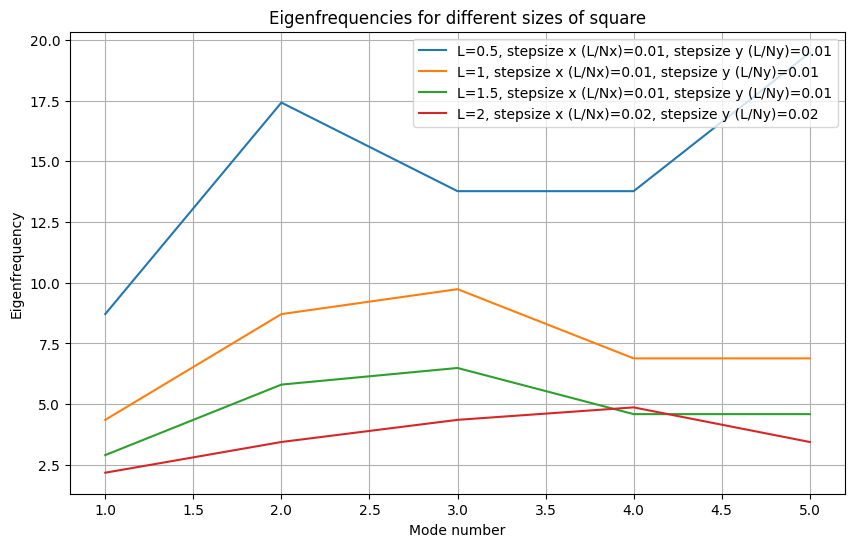

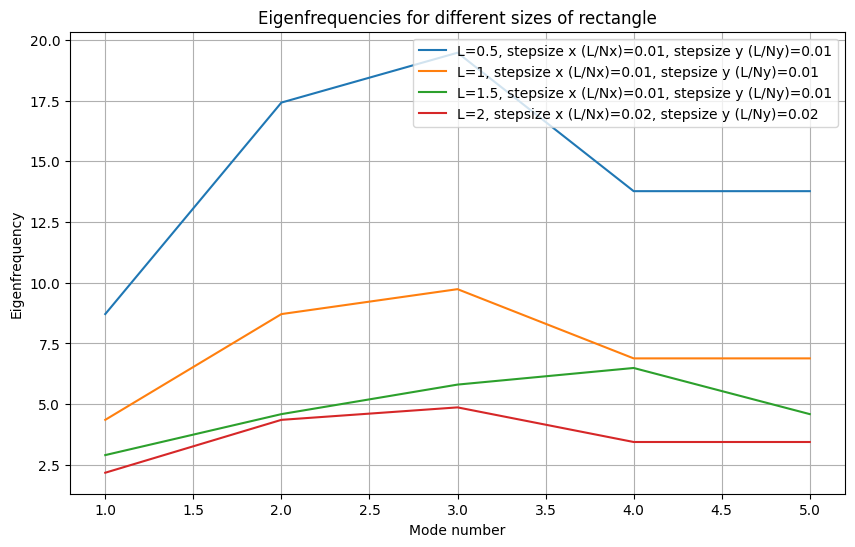

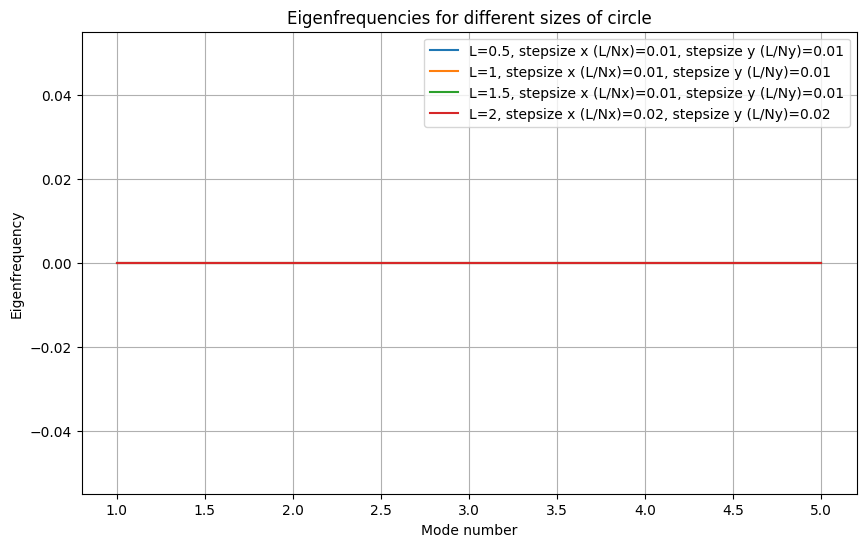

In [21]:
shapes = ['square', 'rectangle', 'circle']
L_values = [(0.5,0.5), (1,1), (1.5,1.5), (2,2)]
n_eigenvals=5
for shape in shapes:
    freqs = calc_eigenfreqs_for_shapes(L_values, shape, n_eigenvals=5)
    plot_eigenfrequencies(L_values, freqs, shape)


In [ ]:
len(eigenvals)

5

In [ ]:
def convert_eigenvalue_to_frequency(eigenvalues, c):
    """Calculate frequency based on omega/2pi, or in this case, as omega = c * sqrt(lambda), c/2pi*sqrt(lambda)"""

    # Assuming eigenvalues K are negative
    eigenfrequencies = (c/np.pi) * np.sqrt(-1*(eigenvalues))
    return eigenfrequencies

___
### C.1 Try sparse matrices instead
scipy.sparse.linalg.eigs() 

In [ ]:
# TODO

### C.2 Show the difference in speed

Timing the executions between sparse and non sparse

In [ ]:
grid = make_grid(shape = (50,50))
eigenvals, eigenvecs = calc_eigenvals_and_eigenvecs(grid)
n_eigenvals_n_vecs = 5
runs = 10
executionTimes_regular = []
executionTimes_sparse = []
for run in range(runs):
    # Regular
    start_time = time.time()
    eigenvals, eigenvecs = calc_eigenvals_and_eigenvecs(grid, solver='regular')
    end_time = time.time()
    executionTimes_regular.append(end_time - start_time)


    # Sparse
    start_time = time.time()
    eigenvals, eigenvecs = calc_eigenvals_and_eigenvecs(grid, solver='sparse')
    end_time = time.time()
    executionTimes_sparse.append(end_time - start_time)

KeyboardInterrupt: 

In [ ]:
# Assuming random and independent samples and normal distribution Z value of 1.96 corresponding to an alpha level of 0.05.


print('execution time sparse (mean over 10 runs)', np.mean(executionTimes_sparse))
print('95% CI Lower:', np.mean(executionTimes_sparse) - 1.96*np.std(executionTimes_sparse)/np.sqrt(len(executionTimes_sparse)))
print('95% CI Top:', np.mean(executionTimes_sparse) + 1.96*np.std(executionTimes_sparse)/np.sqrt(len(executionTimes_sparse)))
print('Execution time regular (mean over 10 runs)', np.mean(executionTimes_regular))
print('95% CI Lower:', np.mean(executionTimes_regular) - 1.96*np.std(executionTimes_regular)/np.sqrt(len(executionTimes_regular)))
print('95% CI Top:', np.mean(executionTimes_regular) + 1.96*np.std(executionTimes_regular)/np.sqrt(len(executionTimes_regular)))

# Perform the t-test
t_statistic, p_value = stats.ttest_ind(executionTimes_sparse, executionTimes_regular)
# Print the results
print('t-statistic:', t_statistic)
print('p-value:', p_value)

execution time sparse (mean over 10 runs) 8.315791964530945
95% CI Lower: 8.196956123829265
95% CI Top: 8.434627805232624
Execution time regular (mean over 10 runs) 286.9210233449936
95% CI Lower: 285.44845071402585
95% CI Top: 288.3935959759614
t-statistic: -350.6552152575646
p-value: 5.719243595848368e-36


In [ ]:
# def plot_frequency_vs_L(eigenvalues, c, Nx, Ny, Lx, Ly):
#     eigenfrequencies = convert_eigenvalue_to_frequency(eigenvalues, c, n_eigenvals_n_vecs=5, solver='sparse')
#     plt.plot(eigenfrequencies, Lx)
#     plt.title('Eigenfrequencies')
#     plt.show()

SyntaxError: expected ':' (4231298314.py, line 1)

In [ ]:
print(len(eigenvecs))

200


___
### E.1 Construct time-dependent solutions

In [ ]:
def sol_wave(eigenvec, k, t, A,B, c):
    return (A * np.sin( c * k * t) + B * np.cos(c * k * t)) * eigenvec

In [ ]:
def update(t, eigenvec, eigenval, fig, ax, cax, A = 1, B = 0, c = 1):
    wave_solution = sol_wave(eigenvec, eigenval, t, A, B, c)
    cax.set_array(wave_solution)
    ax.set_title(f'Wave Evolution, Mode {mode_number}, Time: {t:.2f}s, λ={eigenval:.2f}')
    return cax,

def save_animation(eigenvec, eigenval, mode_number, interval=50, fps=10):
    fig, ax = plt.subplots(figsize=(6, 6))
    cax = ax.imshow(eigenvec, cmap='viridis', interpolation='nearest')
    ax.set_title(f'Wave Evolution, Mode {mode_number}')
    fig.colorbar(cax, ax=ax)  # Add a color bar to the figure
    frames = np.linspace(0, 2 * np.pi / eigenval, 100)
    ani = animation.FuncAnimation(fig, update, fargs=(eigenvec, eigenval, fig, ax, cax), frames=frames, interval=interval)
    writer = animation.FFMpegWriter(fps=fps)
    ani.save(f'animation_mode_{mode_number}.mp4', writer=writer)
    plt.close(fig)

In [ ]:
# Generating data for wave animation
grid = make_grid(shape=(50, 50))
eigenvals, eigenvecs = calc_eigenvals_and_eigenvecs(grid, n_eigenvals_n_vecs=500)

Nx = Ny = 50


A = 1
B = 0
c = 1

c:\Users\nitai\anaconda3\envs\scicomp\Lib\site-packages\scipy\sparse\_index.py:102: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  self._set_intXint(row, col, x.flat[0])


In [ ]:
# Animating the wave evolution
A = 1
B = 0
c = 1

num_modes_to_animate = 5 
for mode_number in range(num_modes_to_animate):
    eigenvec = eigenvecs[:, mode_number].reshape(Nx, Ny)
    eigenval = eigenvals[mode_number]
    save_animation(eigenvec, eigenval, mode_number)

### E.2 Show how the first few eigenmodes behave in time

In [ ]:
# TODO

### E.3 Make an animated plot of some eigenmodes for one of the three systems

In [ ]:
# TODO

___

## 1.2  Direct methods for solving steady state problems
On a circular disk with radius 2 centered on the origin and a source at 0.6,1.2)

In [ ]:
# Define radius of disk, points per side of square grid (N) and source location
SOURCE_X,SOURCE_Y = 0.6,1.2
RADIUS = 2
N = 50

# Create circle mask
x = np.linspace(-RADIUS, RADIUS, N)
y = np.linspace(-RADIUS, RADIUS, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
circle_mask = np.where(R > 2, 0, 1)

# Create grid space, adding the source and masking points outside circle
domain = np.zeros((N,N))#*0.5
domain[ int((SOURCE_Y + RADIUS)/(2*RADIUS/(N - 1))), int((SOURCE_X+RADIUS)/(2*RADIUS/(N - 1)))] = 1
domain *= circle_mask

# Save the coordinates of the source
source_coordinates = np.where(domain == 1)
#source_k = int((source_coordinates[0])*N + source_coordinates[1]+1)
i_s,j_s = source_coordinates[0][0],source_coordinates[1][0]


# 1. We need to put a -1 in its neighbors and 4 in its value
# But the part that may fall outside the boundary should be distributed in other stencils that are inside the domain! -> actually NOT, as long as outside circle we force the 0s
# Also, the source row of M should have only a 1 at the source point itself! It does not depend on other values
def check_bounds(array, x, y):
    return True if 0 <= x < len(array) and 0 <= y < len(array[0]) else False

# Innitialize matrix M
M = np.zeros((N*N, N*N))

# Iterate all its rows to fill it
for k in range(M.shape[0]):
    # For each row, get the associated coordinates of the grid point it represents
    i, j = divmod(k, N)   

    # If our current row is the row corresponding to the source, we just put a 1 on it
    # And leave the other values as 0
    if (i,j) == source_coordinates:
        M[k,k] = 1

    # If the current row is of a point outside the circle we ignore it and leave it at zeros
    # Otherwise we need to add the +4 on the main element and then the -1 on the stencils
    elif circle_mask[i,j] == 1:
        M[k,k] += 4
        
        # For each remaining stencil we want to fill it with -1 if the point is within our domain
        # If our stencil point actually falls outside the grid we put the -1 on the centered element instead
        # Interestingly: we still put a -1 on the element if its within the grid EVEN if its outside the circle!
    
        # (i+1,j)
        if check_bounds(circle_mask, i+1, j):
            #if circle_mask[i+1,j] == 1:
                #if j != j_s:
            INDEX = int((i+1)*N + j)
            M[k,INDEX] -= 1
            #else:
            #    M[k,k] -= 1
        else:
            M[k,k] -= 1

        # (i-1,j)
        if check_bounds(circle_mask, i-1, j):
            #if circle_mask[i-1,j] == 1:
            #if j != j_s:
            INDEX = int((i-1)*N + j)
            M[k,INDEX] -= 1
            #else:
            #    M[k,k] -= 1
        else:
            M[k,k] -= 1

        # (i,j+1)
        if check_bounds(circle_mask, i, j+1):
            #if circle_mask[i,j+1] == 1:
            #if j != j_s:
            INDEX = int((i)*N + j+1)
            M[k,INDEX] -= 1
            #else:
            #    M[k,k] -= 1
        else:
            M[k,k] -= 1

        # (i,j-1)
        if check_bounds(circle_mask, i, j-1):
            #if circle_mask[i,j-1] == 1:
            #if j != j_s:
            INDEX = int((i)*N + j-1)
            M[k,INDEX] -= 1
            #else:
            #    M[k,k] -= 1
        else:
            M[k,k] -= 1


# To avoid the matrix M from being singular, making it impossible to solve the linear system
# We also need to add a little noise, which we add to the main diagonal
regularization = 1e-8 * np.identity(N**2)  
regularization
M += regularization

# Create vector b: each value has sum of boundary conditions of each cell
# which in this case is 0s on rows outside domain and a 1 on the row of the source 
# (for it always has concentration of 1, otherwise that source value will be diffused around)
b = domain.flatten()

# Show domain (we put 0.5 value on circle points to see them)
"""
domain_display = np.ones((N,N))*0.5
domain_display[ int((SOURCE_Y + RADIUS)/(2*RADIUS/(N - 1))), int((SOURCE_X+RADIUS)/(2*RADIUS/(N - 1)))] = 1
domain_display *= circle_mask
plt.imshow(domain_display, extent=(-2, 2, -2, 2), origin='lower') # cmap='binary'
plt.title(r'$c_0(x,y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([-2,0,SOURCE_X,2])
plt.yticks([-2,0,SOURCE_Y,2])
plt.colorbar(fraction=0.046, pad=0.04)
plt.show()
"""

# Show matrix m
"""
plt.imshow(M)
#for (j,i),label in np.ndenumerate(M):
#    if int(label) != 0:
#        plt.text(i,j,str(int(label)),ha='center',va='center')
plt.title('M')
plt.colorbar()
plt.show()
"""

# Show vector b
"""
plt.imshow(domain,vmin=0,vmax=1,extent=(-2, 2, -2, 2), origin='lower')
plt.title('b (not flatteded)')
plt.colorbar()
plt.show()
"""

# Solve for concentration vector c using standard library methods
c = np.linalg.solve(M, b)

# Reshape the c vector back to 2D matrix
c_grid = np.reshape(c,(N,N))



# Print the minimum and maximum concentrations of the solution
print('Solved')
print('Min c:',np.min(c))
print('Max c:',np.max(c))
# TODO: Set the c_grid in terms of x and y in [-2,2], not (0,N)

# Plot result
"""
plt.imshow(c_grid,cmap=plt.cm.plasma,vmin=0,vmax=1,extent=(-2, 2, -2, 2), origin='lower')
plt.title(r'$Solved - c(x,y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([-2,0,SOURCE_X,2])
plt.yticks([-2,0,SOURCE_Y,2])
plt.colorbar()
plt.show()
plt.show()
"""



Solved
Min c: -1.1573809319959105e-07
Max c: 0.9999999900000002


"\nplt.imshow(c_grid,cmap=plt.cm.plasma,vmin=0,vmax=1,extent=(-2, 2, -2, 2), origin='lower')\nplt.title(r'$Solved - c(x,y)$')\nplt.xlabel('x')\nplt.ylabel('y')\nplt.xticks([-2,0,SOURCE_X,2])\nplt.yticks([-2,0,SOURCE_Y,2])\nplt.colorbar()\nplt.show()\nplt.show()\n"

In [ ]:
c_grid.shape

(100, 100)

### G.1 Find steady state concentrations
Discretizing the diffusion equation

### G.2 Plot the solution

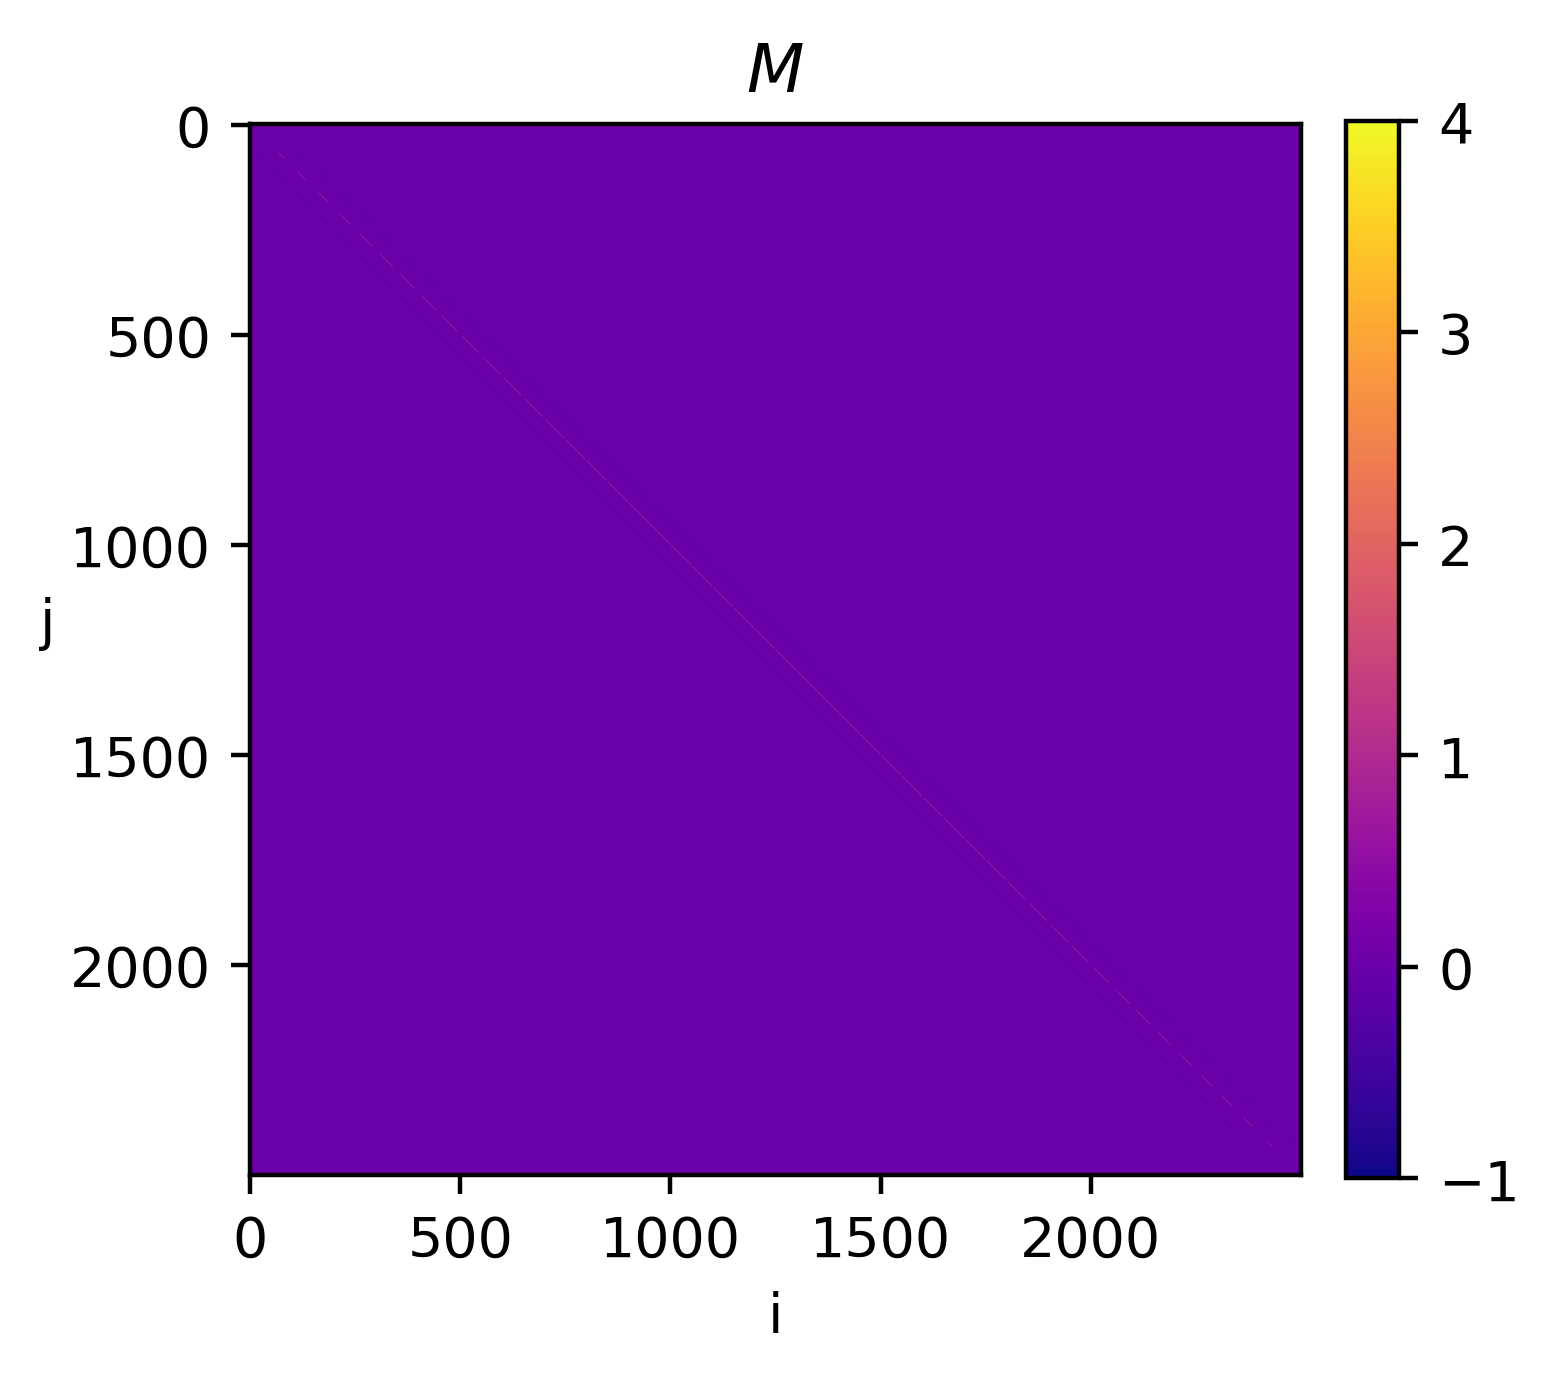

In [ ]:
# Also plot M

# Show matrix m
#for (j,i),label in np.ndenumerate(M):
#    if int(label) != 0:
#        plt.text(i,j,str(int(label)),ha='center',va='center')

plt.figure(figsize=(4,4),dpi=400)
plt.imshow(M,cmap=plt.cm.plasma)
plt.title(r'$M$')
plt.xlabel('i')
plt.ylabel('j', rotation=0)
#plt.xticks([-2,0,SOURCE_X,2],['-2','0',str(round(SOURCE_X,1)),'2'])
#plt.yticks([-2,0,SOURCE_Y,2],['-2','0',str(round(SOURCE_Y,1)),'2'])
#plt.colorbar()
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(f'2.1_M_{c_grid.shape[0]}.png',bbox_inches='tight')
plt.show()


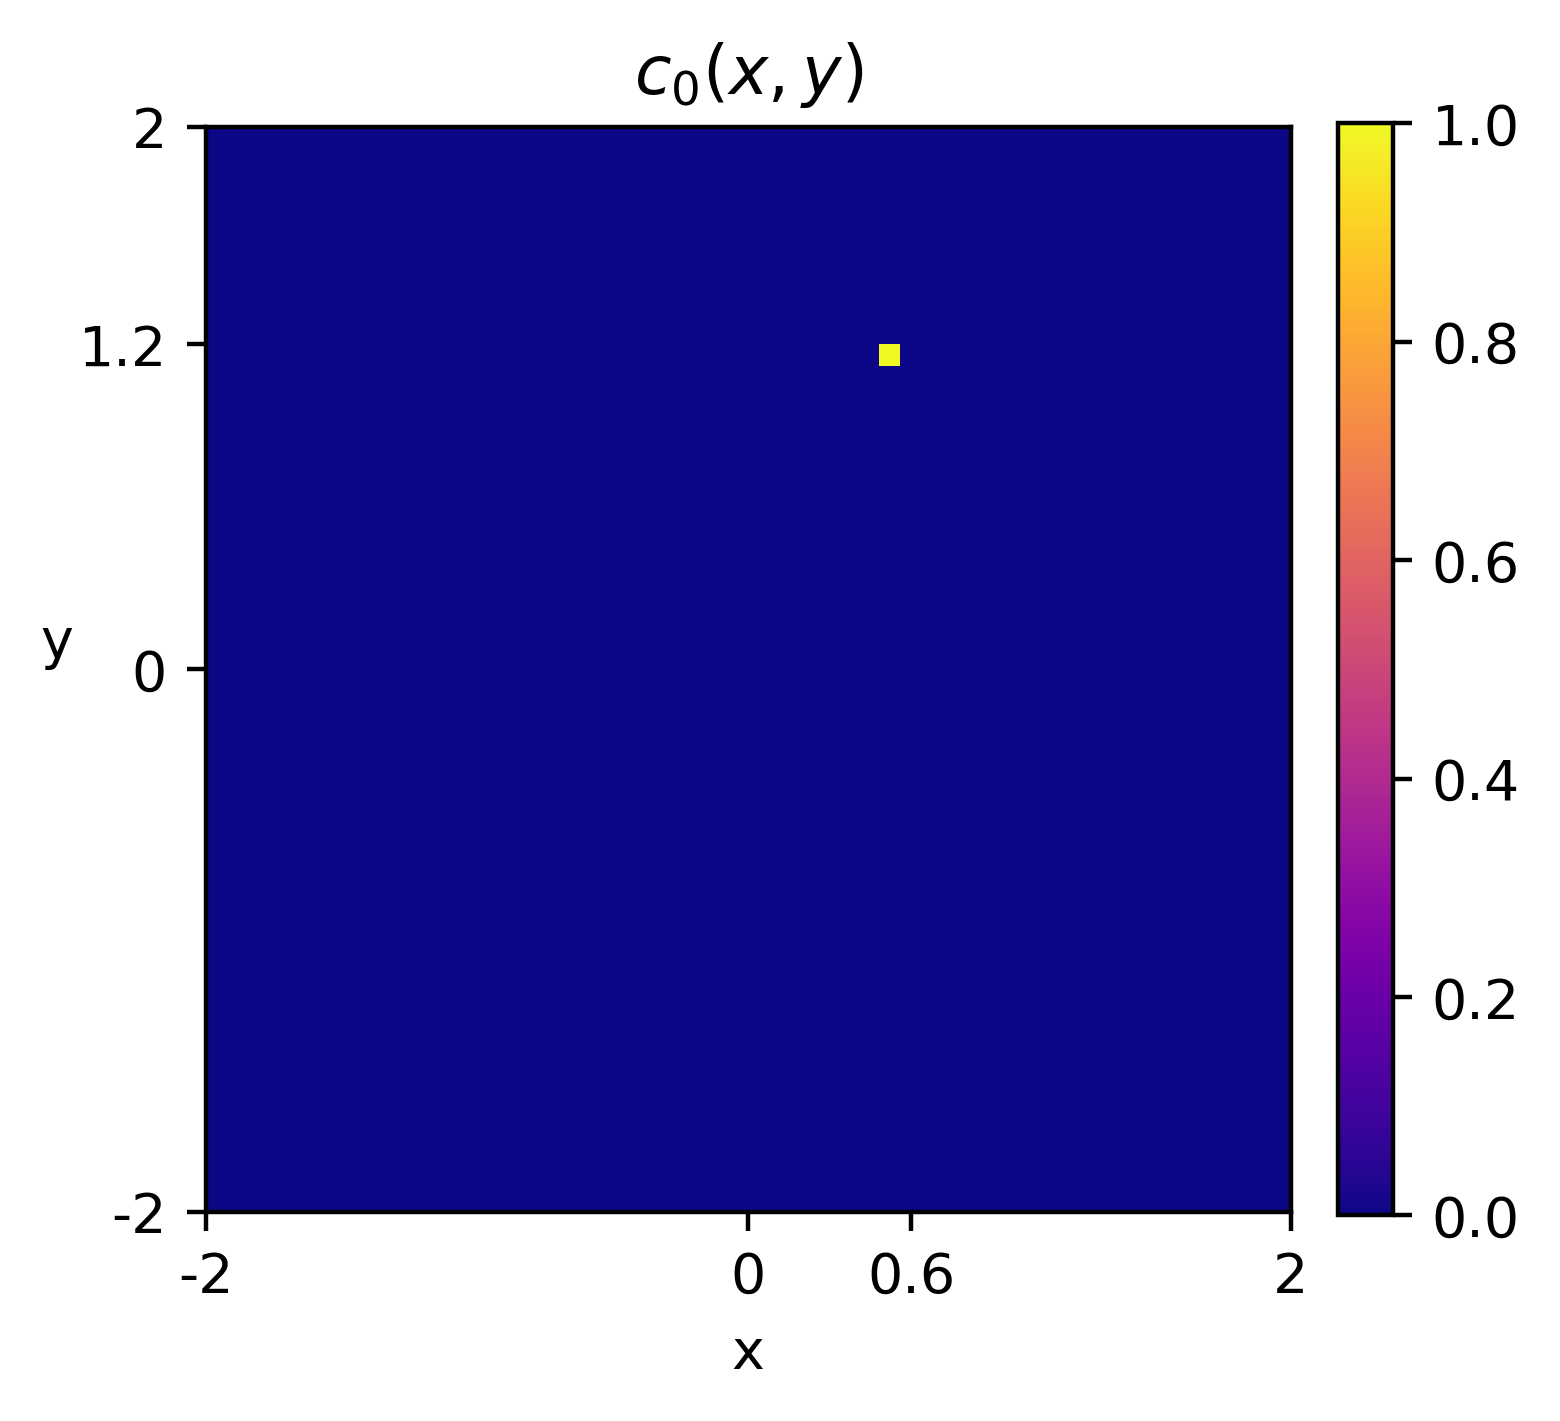

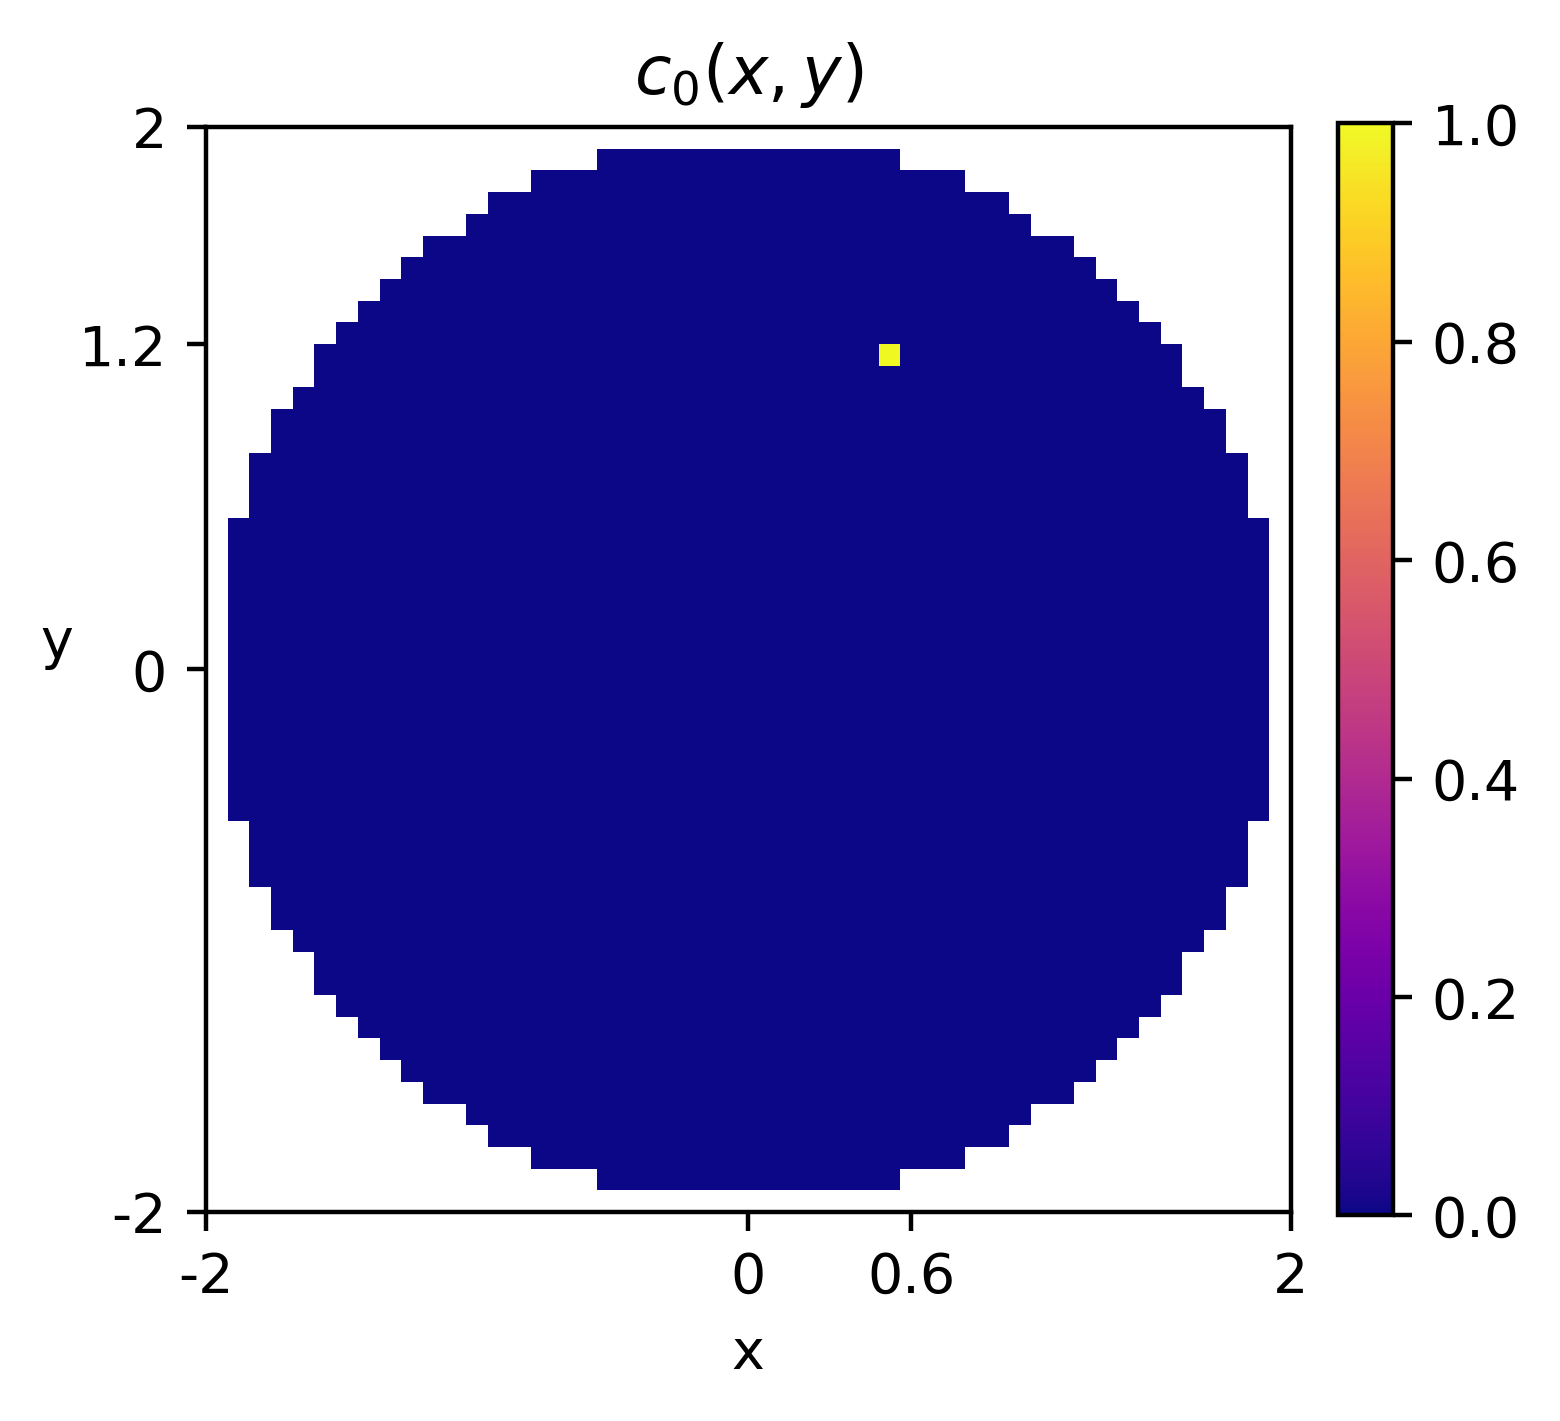

In [ ]:
# High resolution domain plot
# Uses the mask to hide values outside circle

# Put a -1 on the points outside circle mask
circle_mask_for_plotting = np.where(R > 2, -1, 0)
domain_masked = domain + circle_mask_for_plotting

# Customize the colormap to set the -1 points outside circle to white
cmap_plot = copy.copy(plt.cm.plasma)
cmap_plot.set_under('white')


plt.figure(figsize=(4,4),dpi=400)
plt.imshow(domain,cmap=cmap_plot,vmin=0,vmax=1,extent=(-2, 2, -2, 2), origin='lower')
plt.title(r'$c_0(x,y)$')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.xticks([-2,0,SOURCE_X,2],['-2','0',str(round(SOURCE_X,1)),'2'])
plt.yticks([-2,0,SOURCE_Y,2],['-2','0',str(round(SOURCE_Y,1)),'2'])
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(f'2.1_domain_original_{c_grid.shape[0]}.png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4),dpi=400)
plt.imshow(domain_masked,cmap=cmap_plot,vmin=0,vmax=1,extent=(-2, 2, -2, 2), origin='lower')
plt.title(r'$c_0(x,y)$')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.xticks([-2,0,SOURCE_X,2],['-2','0',str(round(SOURCE_X,1)),'2'])
plt.yticks([-2,0,SOURCE_Y,2],['-2','0',str(round(SOURCE_Y,1)),'2'])
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(f'2.1_domain_masked_{c_grid.shape[0]}.png',bbox_inches='tight')
plt.show()

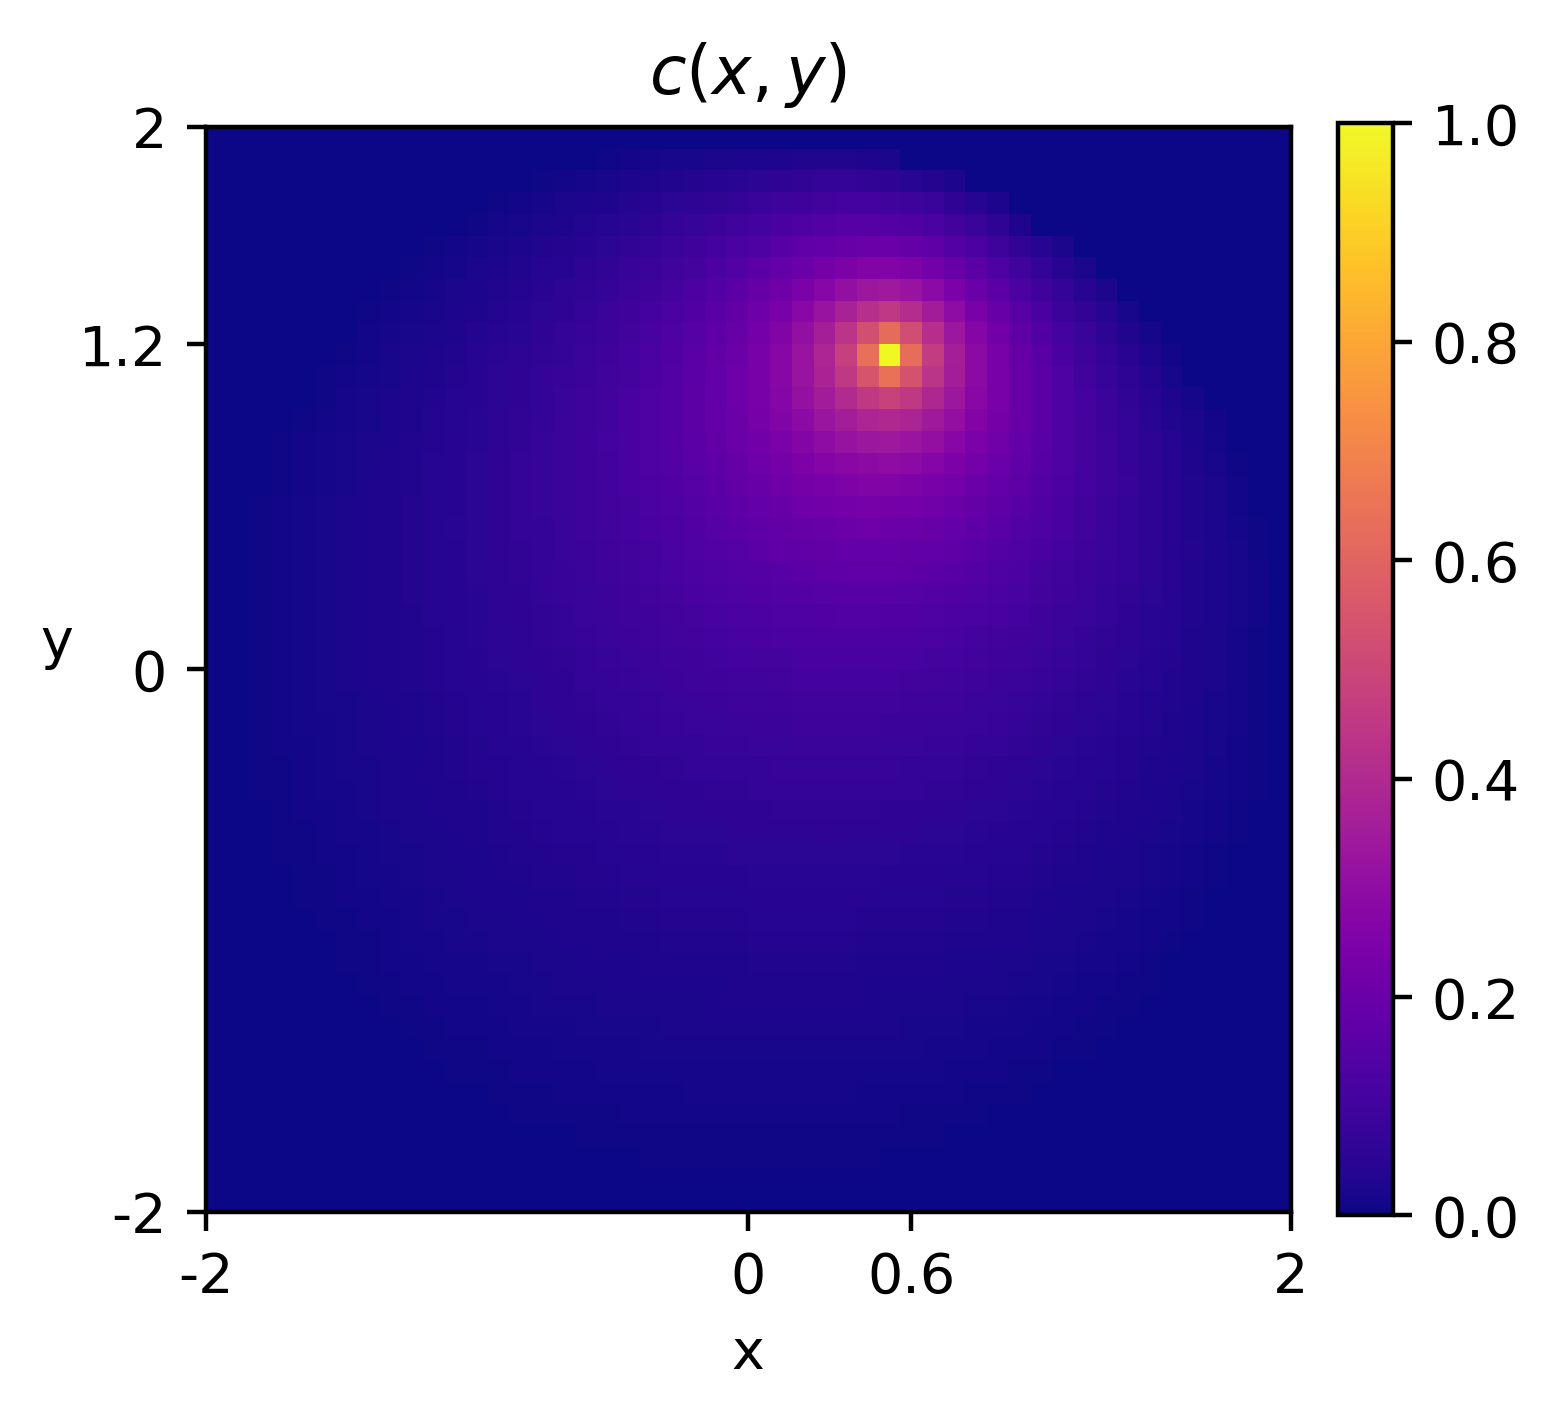

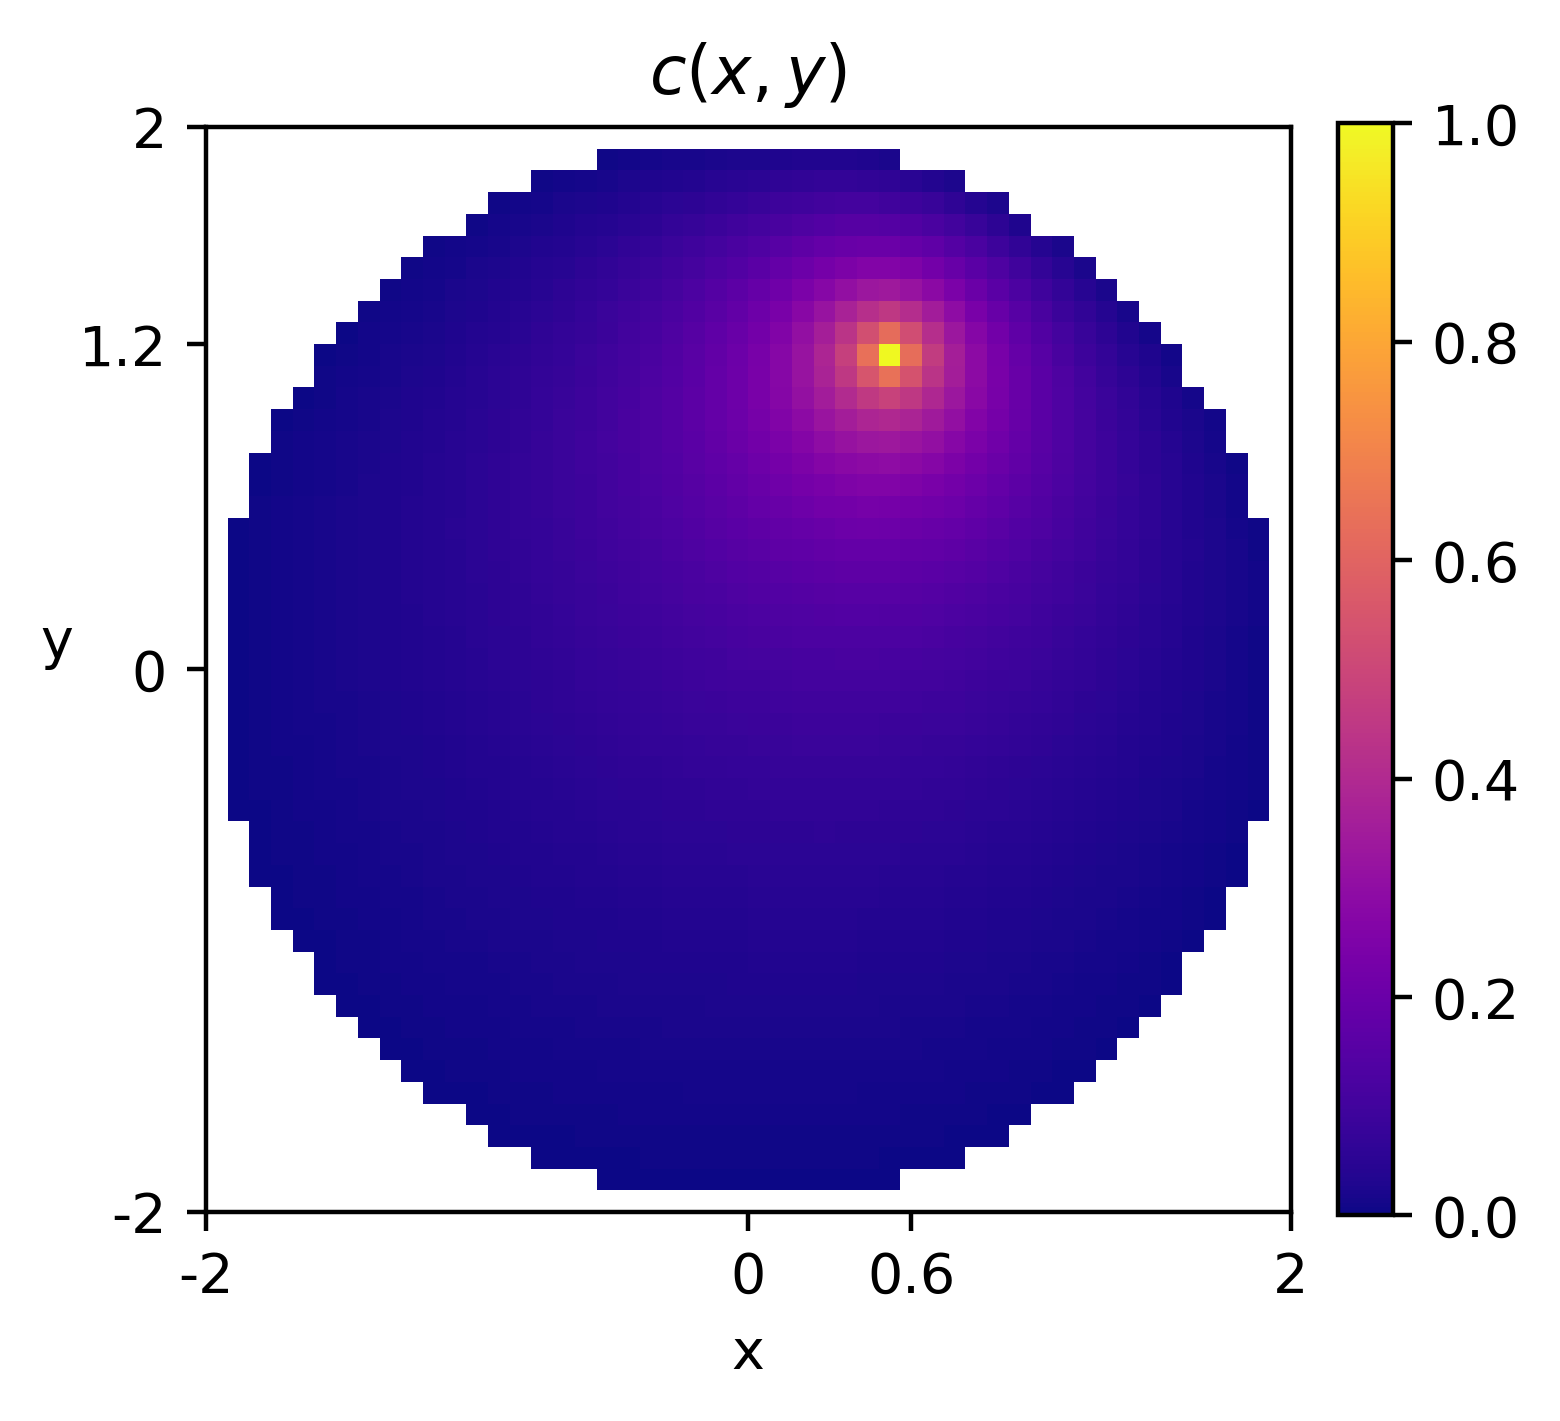

In [ ]:
# High resolution solution plot


# Put a -1 on the points outside circle mask
circle_mask_for_plotting = np.where(R > 2, -1, 0)
c_grid_masked = c_grid + circle_mask_for_plotting

# Customize the colormap to set the -1 points outside circle to white
cmap_plot = copy.copy(plt.cm.plasma)
cmap_plot.set_under('white')


plt.figure(figsize=(4,4),dpi=400)
plt.imshow(c_grid,cmap=plt.cm.plasma,vmin=0,vmax=1,extent=(-2, 2, -2, 2), origin='lower')
plt.title(r'$c(x,y)$')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.xticks([-2,0,SOURCE_X,2],['-2','0',str(round(SOURCE_X,1)),'2'])
plt.yticks([-2,0,SOURCE_Y,2],['-2','0',str(round(SOURCE_Y,1)),'2'])
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(f'2.1_solution_original_{c_grid.shape[0]}.png',bbox_inches='tight')
plt.show()

plt.figure(figsize=(4,4),dpi=400)
plt.imshow(c_grid_masked,cmap=cmap_plot,vmin=0,vmax=1,extent=(-2, 2, -2, 2), origin='lower')
plt.title(r'$c(x,y)$')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
plt.xticks([-2,0,SOURCE_X,2],['-2','0',str(round(SOURCE_X,1)),'2'])
plt.yticks([-2,0,SOURCE_Y,2],['-2','0',str(round(SOURCE_Y,1)),'2'])
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.savefig(f'2.1_solution_masked_{c_grid.shape[0]}.png',bbox_inches='tight')
plt.show()



___
### H.1 Explain how matrix M and vector b are constructed
And how the boundary conditions are taken into account
In document!

[ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10.]


NameError: name 'im' is not defined

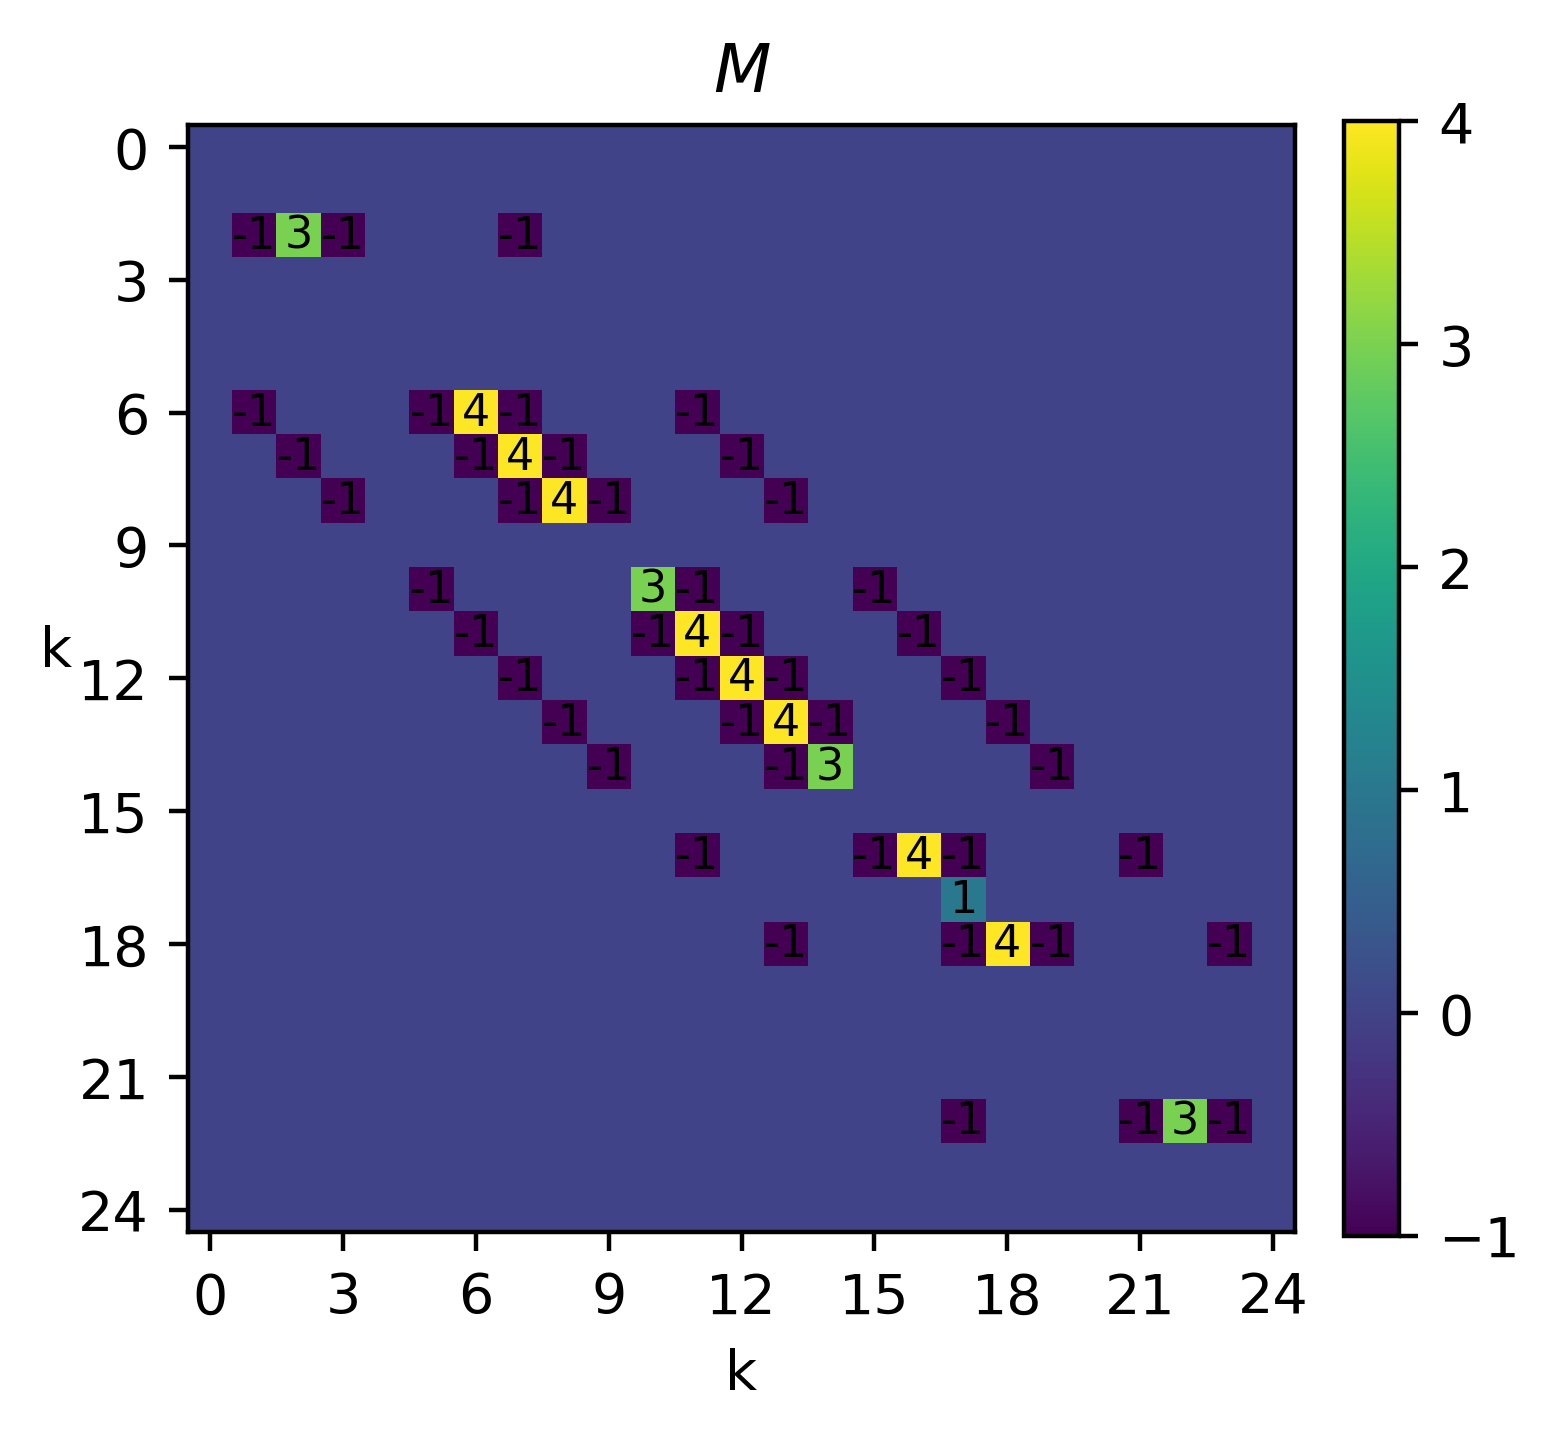

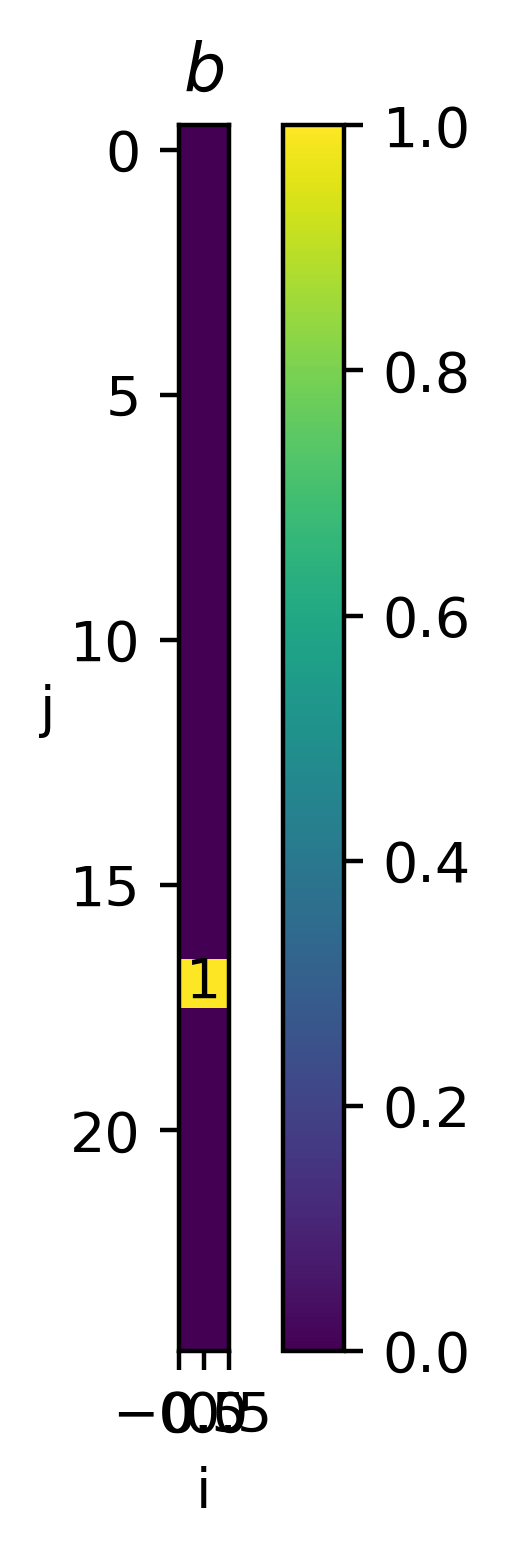

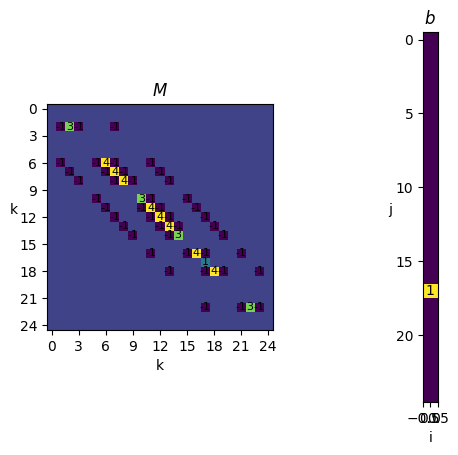

In [ ]:
# Solve for a small value
# Plot matrix M with numbers
SOURCE_X,SOURCE_Y = 0.6,1.2
RADIUS = 2
N = 5

x = np.linspace(-RADIUS, RADIUS, N)
y = np.linspace(-RADIUS, RADIUS, N)
X, Y = np.meshgrid(x, y)
R = np.sqrt(X**2 + Y**2)
circle_mask = np.where(R > 2, 0, 1)

domain = np.zeros((N,N))#*0.5
domain[ int((SOURCE_Y + RADIUS)/(2*RADIUS/(N - 1))), int((SOURCE_X+RADIUS)/(2*RADIUS/(N - 1)))] = 1
domain *= circle_mask

source_coordinates = np.where(domain == 1)
i_s,j_s = source_coordinates[0][0],source_coordinates[1][0]

def check_bounds(array, x, y):
    return True if 0 <= x < len(array) and 0 <= y < len(array[0]) else False

M = np.zeros((N*N, N*N))

for k in range(M.shape[0]):
    i, j = divmod(k, N)   
    if (i,j) == source_coordinates:
        M[k,k] = 1
    elif circle_mask[i,j] == 1:
        M[k,k] += 4

        if check_bounds(circle_mask, i+1, j):
            INDEX = int((i+1)*N + j)
            M[k,INDEX] -= 1
        else:
            M[k,k] -= 1

        if check_bounds(circle_mask, i-1, j):
            INDEX = int((i-1)*N + j)
            M[k,INDEX] -= 1
        else:
            M[k,k] -= 1

        if check_bounds(circle_mask, i, j+1):
            INDEX = int((i)*N + j+1)
            M[k,INDEX] -= 1
        else:
            M[k,k] -= 1

        if check_bounds(circle_mask, i, j-1):
            INDEX = int((i)*N + j-1)
            M[k,INDEX] -= 1
        else:
            M[k,k] -= 1


regularization = 1e-8 * np.identity(N**2)  
regularization
M += regularization

b = domain.flatten()

# Show domain (we put 0.5 value on circle points to see them)
"""
circle_mask_for_plotting = np.where(R > 2, -1, 0)
domain_masked = domain + circle_mask_for_plotting

cmap_plot = copy.copy(plt.cm.plasma)
cmap_plot.set_under('white')
domain_display = np.ones((N,N))*0.5
domain_display[ int((SOURCE_Y + RADIUS)/(2*RADIUS/(N - 1))), int((SOURCE_X+RADIUS)/(2*RADIUS/(N - 1)))] = 1
domain_display *= circle_mask

plt.figure(figsize=(4,4),dpi=100)
plt.imshow(domain_display) # cmap='binary'
plt.title(r'$B_{N \times N}$')
plt.xlabel('x')
plt.ylabel('y', rotation=0)
#plt.xticks([-2,0,2],['-2','0',str(round(SOURCE_X,1)),'2'])
#plt.yticks([-2,0,2],['-2','0',str(round(SOURCE_Y,1)),'2'])
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()
"""

# Show matrix m
plt.figure(figsize=(4,4),dpi=400)
plt.imshow(M)
for (j,i),label in np.ndenumerate(M):
    if int(label) != 0:
        plt.text(i,j,str(int(label)),ha='center',va='center',size=8)
plt.title(r'$M$')
plt.xlabel('k')
plt.ylabel('k', rotation=0)
plt.xticks(np.linspace(0,N**2-1,9),[str(int(x)) for x in np.linspace(0,N**2-1,9)])
plt.yticks(np.linspace(0,N**2-1,9),[str(int(x)) for x in np.linspace(0,N**2-1,9)])

plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
#plt.show()

print(np.linspace(1,N*2,N*2))


# Show b
plt.figure(figsize=(4,4),dpi=400)
plt.imshow(np.expand_dims(b, axis=1))
for (j,i),label in np.ndenumerate(np.expand_dims(b, axis=1)):
    if int(label) != 0:
        plt.text(i,j,str(int(label)),ha='center',va='center')
plt.title(r'$b$')
plt.xlabel('i')
plt.ylabel('j', rotation=0)
#plt.xticks([-2,0,2],['-2','0',str(round(SOURCE_X,1)),'2'])
#plt.yticks([-2,0,2],['-2','0',str(round(SOURCE_Y,1)),'2'])
plt.colorbar(fraction=0.046, pad=0.04)
plt.tight_layout()
#plt.show()



# Combined plot
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(M)
for (j,i),label in np.ndenumerate(M):
    if int(label) != 0:
        ax1.text(i,j,str(int(label)),ha='center',va='center',size=8)
ax1.set_title(r'$M$')
ax1.set_xlabel('k')
ax1.set_ylabel('k', rotation=0)
ax1.set_xticks(np.linspace(0,N**2-1,9),[str(int(x)) for x in np.linspace(0,N**2-1,9)])
ax1.set_yticks(np.linspace(0,N**2-1,9),[str(int(x)) for x in np.linspace(0,N**2-1,9)])

ax2.imshow(np.expand_dims(b, axis=1))
for (j,i),label in np.ndenumerate(np.expand_dims(b, axis=1)):
    if int(label) != 0:
        ax2.text(i,j,str(int(label)),ha='center',va='center')
ax2.set_title(r'$b$')
ax2.set_xlabel('i')
ax2.set_ylabel('j', rotation=0)
#plt.xticks([-2,0,2],['-2','0',str(round(SOURCE_X,1)),'2'])
#plt.yticks([-2,0,2],['-2','0',str(round(SOURCE_Y,1)),'2'])

#ax2.colorbar(fraction=0.046, pad=0.04)
#plt.tight_layout()

fig.colorbar(im, ax1)
plt.show()


# Print the minimum and maximum concentrations of the solution
#print('Solved')
#print('Min c:',np.min(c))
#print('Max c:',np.max(c))
# TODO: Set the c_grid in terms of x and y in [-2,2], not (0,N)

# Plot result
"""
plt.imshow(c_grid,cmap=plt.cm.plasma,vmin=0,vmax=1,extent=(-2, 2, -2, 2), origin='lower')
plt.title(r'$Solved - c(x,y)$')
plt.xlabel('x')
plt.ylabel('y')
plt.xticks([-2,0,SOURCE_X,2])
plt.yticks([-2,0,SOURCE_Y,2])
plt.colorbar()
plt.show()
plt.show()
"""



TODO

___
## 1.3 [Bonus] The leapfrog method
Efficient time integration

### I.1 Implement the leapfrog method for a simple 1D harmonic oscillator

In [ ]:
# TODO

### I.2 Explain
- How the steps are discretized
- How the initial velocity at the half step is calculated
- Does this affect the overall accuracy of the method?

### I.3 Plot position and velocity
For a few values of k

In [ ]:
# TODO

### I.4 Demonstrate that the leapfrog method is a symetric integrator
By comparing it with a non-stable higher order integrator like RK45

In [ ]:
# TODO

___
### J.1 Add an external time-dependent sinusoidal driving force
To the oscillator

In [ ]:
# TODO

### J.2 What happens when the driving force is close to the original frequency of the oscillator?

TODO

**Hipothesis**: We should see resonance. If so, analytical tools could give us bound on module with resonance, we could then verify experimentally if we get that value

### J.3 Show a phase plot (v,x) of various frequencies

In [ ]:
# TODO